Quadratic Discriminant Analysis is based on the idea of finding a quadratic combination of features that separates two or more classes of objects. Bayes Theorem is used to classify new data points: QDA makes predictions by calculating the probability of whether an input data set will belong to a particular output.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Quadratic discriminant analysis assumes that the underlying data distribution is normal, but relaxes the assumption that each class has equal covariance matrix. Therefore, we use the transformed (through Box-Cox trasnformation) data.

In [2]:
# import training set
train = pd.read_csv('/Users/alessia/Desktop/churn/trans.csv')

# only select the transformed (continuous) predictor variables
X = train[['CreditScore_trans', 'Age_trans', 'EstimatedSalary_trans', 'Balance', 'Tenure', 'NumOfProducts']]
y = train['Exited']

In [3]:
# split training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [4]:
# parameter grid
param_grid = {
    'reg_param': [0, 0.2, 0.4]
}

# Quadratic Discriminant Analysis
QDA_classifier = QuadraticDiscriminantAnalysis()
grid_search = GridSearchCV(estimator=QDA_classifier, param_grid=param_grid,
                           scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train.values.ravel()) 

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: {:.4f}".format(grid_search.best_score_))

Best Parameters:  {'reg_param': 0}
Best AUC: 0.8179


In [5]:
QDA = grid_search.best_estimator_ # select best estimator based on best parameters

# refit model on training set
QDA.fit(X = X_train, y = y_train.values.ravel())

# predict on the training set
y_pred_train = QDA.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy_train:.4f}")

# AUC on training set
y_probs_train = QDA.predict_proba(X_train)[:, 1] # compute probabilities

# ROC curve
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_probs_train)

# AUC
roc_auc_train = auc(fpr_train, tpr_train)
print('AUC on training set is {}'.format(roc_auc_train))


# predict on the test set
y_pred_test = QDA.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy_test:.4f}")

# AUC on test set
y_probs_test = QDA.predict_proba(X_test)[:, 1] # compute probabilities

# ROC curve
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_probs_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print('AUC on test set is {}'.format(roc_auc_test))

Accuracy on training set: 0.8198
AUC on training set is 0.8181591583208598
Accuracy on test set: 0.8217
AUC on test set is 0.8200397631766382


In [6]:
# define confusion matrix
import seaborn as sns

classes = ['Non churner', 'Churner']

def plot_confusionmatrix(y_train_pred,y_train):
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='pink', fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

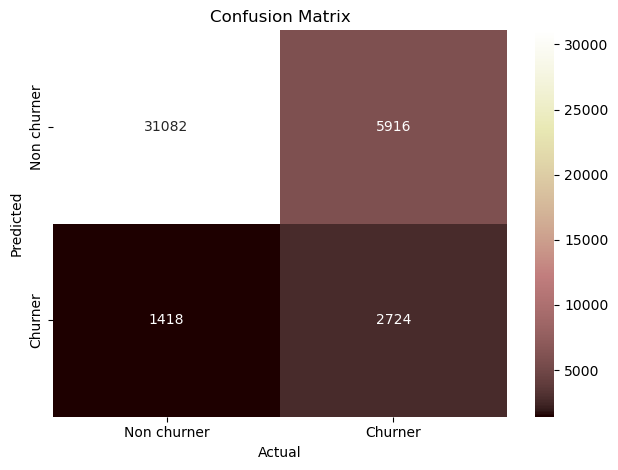

In [7]:
# confusion matrix
plt.title('Confusion matrix')
plot_confusionmatrix(y_pred_test,y_test)

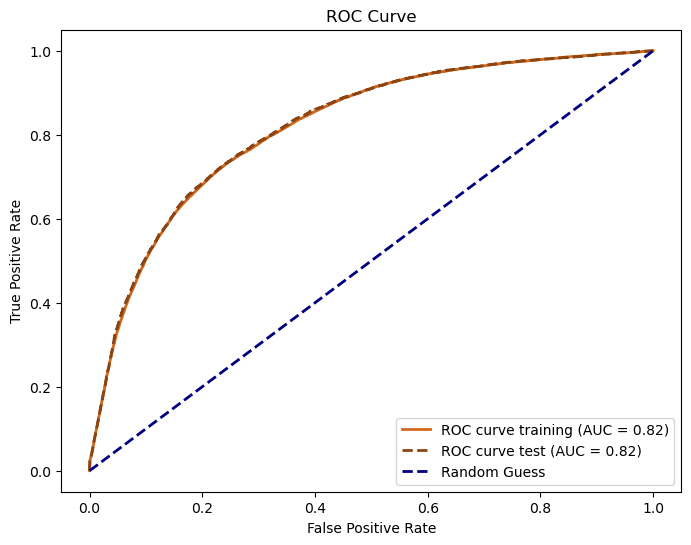

In [8]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='chocolate', lw=2, label=f'ROC curve training (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color = 'saddlebrown', linestyle='--', lw= 2, label=f'ROC curve test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.plot([])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [9]:
# compute other evaluation measures
from sklearn.metrics import precision_score, recall_score, f1_score
# precision (recall)
precision_test = precision_score(y_test, y_pred_test)
# recall
recall_test = recall_score(y_test, y_pred_test)
# f1-measure
f1_test = f1_score(y_test, y_pred_test)

print('Precision on the test set is {}'.format(precision_test))
print('Recall on the test set is {}'.format(recall_test))
print('f1-measure on the test set is {}'.format(f1_test))

Precision on the test set is 0.6576533075808788
Recall on the test set is 0.31527777777777777
f1-measure on the test set is 0.42622437803160695


In [10]:
# save model
model_name='qda.pkl'
model_file=open(model_name,'wb')
pickle.dump(QDA, model_file)
model_file.close()

# open model
model_file=open(model_name, 'rb')
Model=pickle.load(model_file)